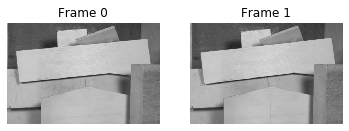

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image0 = cv2.imread("assets/Wooden/frame10.png", cv2.IMREAD_GRAYSCALE)
image1 = cv2.imread("assets/Wooden/frame11.png", cv2.IMREAD_GRAYSCALE)
images = [image0, image1]
show0 = cv2.cvtColor(images[0], cv2.COLOR_GRAY2RGB)
show1 = cv2.cvtColor(images[1], cv2.COLOR_GRAY2RGB)

fig = plt.figure(0)
showFig = fig.add_subplot(1, 2, 1)
plt.imshow(show0)
showFig.set_title("Frame 0")
showFig.axis('off')
showFig = fig.add_subplot(1, 2, 2)
plt.imshow(show1)
showFig.set_title("Frame 1")
showFig.axis('off')
plt.show()

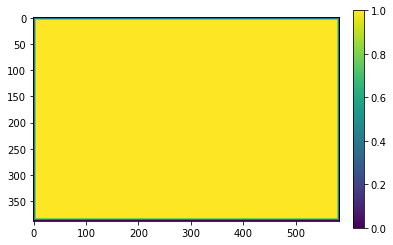

In [40]:
fig = plt.figure(1)

c0 = np.minimum(1, 1/5*np.minimum(np.arange(images[0].shape[0])[:, None], np.arange(images[1].shape[1])))
c0 = np.minimum(c1, 1/5*np.minimum(images[0].shape[0] - 1 - np.arange(images[0].shape[0])[:, None], images[0].shape[1] - 1 - np.arange(images[0].shape[1])))
c1 = c0

plt.imshow(c0)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [41]:
sigma=4.0
sigma_flow=4.0
num_iter=3
model='constant'
mu=0

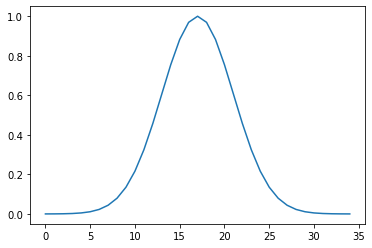

In [42]:
fig = plt.figure(2)

n = int(4*sigma + 1)
x = np.arange(-n, n + 1, dtype=np.int)
a = np.exp(-x**2 / (2 * sigma**2))  # a: applicability kernel [n]

plt.plot(a)
plt.show()

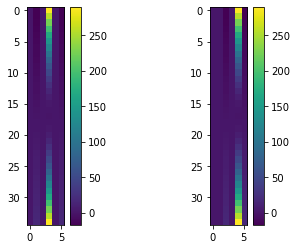

In [31]:
fig = plt.figure(3)

bx = np.stack([np.ones(a.shape), x, np.ones(a.shape), x**2, np.ones(a.shape), x], axis=-1)
by = np.stack([np.ones(a.shape), np.ones(a.shape), x, np.ones(a.shape), x**2, x], axis=-1)

showFig = fig.add_subplot(1, 2, 1)
plt.imshow(bx)
plt.colorbar(fraction=0.075, pad=0.04)
showFig = fig.add_subplot(1, 2, 2)
plt.imshow(by)
plt.colorbar(fraction=0.075, pad=0.04)
plt.show()

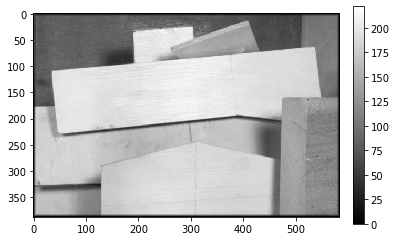

In [39]:
fig = plt.figure(4)

c0f = c0 * images[0]

plt.imshow(c1f, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [43]:
# G and v are used to calculate "r" from the paper: v = G*r
# r is the parametrization of the 2nd order polynomial for f
G = np.empty(list(f.shape) + [bx.shape[-1]]*2)
v = np.empty(list(f.shape) + [bx.shape[-1]])

# Apply separable cross-correlations

# Pre-calculate quantities recommended in paper
ab = np.einsum('i,ij->ij', a, bx)
abb = np.einsum('ij,ik->ijk', ab, bx)

# Calculate G and v for each pixel with cross-correlation
for i in range(bx.shape[-1]):
    for j in range(bx.shape[-1]):
        G[..., i, j] = scipy.ndimage.correlate1d(c, abb[..., i, j], axis=0, mode='constant', cval=0)

    v[..., i] = scipy.ndimage.correlate1d(cf, ab[..., i], axis=0, mode='constant', cval=0)

# Pre-calculate quantities recommended in paper
ab = np.einsum('i,ij->ij', a, by)
abb = np.einsum('ij,ik->ijk', ab, by)

# Calculate G and v for each pixel with cross-correlation
for i in range(bx.shape[-1]):
    for j in range(bx.shape[-1]):
        G[..., i, j] = scipy.ndimage.correlate1d(G[..., i, j], abb[..., i, j], axis=1, mode='constant', cval=0)

    v[..., i] = scipy.ndimage.correlate1d(v[..., i], ab[..., i], axis=1, mode='constant', cval=0)

# Solve r for each pixel
r = np.linalg.solve(G, v)

NameError: name 'f' is not defined

In [ ]:
def poly_exp(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 2D signal, as described by Farneback

    Uses separable normalized correlation

    $f ~ x^T A x + B^T x + C$

    If f[i, j] and c[i, j] are the signal value and certainty of pixel (i, j) then
    A[i, j] is a 2x2 array representing the quadratic term of the polynomial, B[i, j]
    is a 2-element array representing the linear term, and C[i, j] is a scalar
    representing the constant term.

    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel

    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Calculate applicability kernel (1D because it is separable)
    n = int(4*sigma + 1)
    x = np.arange(-n, n + 1, dtype=np.int)
    a = np.exp(-x**2 / (2 * sigma**2))  # a: applicability kernel [n]

    # b: calculate b from the paper. Calculate separately for X and Y dimensions
    # [n, 6]
    bx = np.stack([
        np.ones(a.shape),
        x,
        np.ones(a.shape),
        x**2,
        np.ones(a.shape),
        x
    ], axis=-1)
    by = np.stack([
        np.ones(a.shape),
        np.ones(a.shape),
        x,
        np.ones(a.shape),
        x**2,
        x,
    ], axis=-1)

    # Pre-calculate product of certainty and signal
    cf = c * f

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [bx.shape[-1]]*2)
    v = np.empty(list(f.shape) + [bx.shape[-1]])

    # Apply separable cross-correlations

    # Pre-calculate quantities recommended in paper
    ab = np.einsum('i,ij->ij', a, bx)
    abb = np.einsum('ij,ik->ijk', ab, bx)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(c, abb[..., i, j], axis=0, mode='constant', cval=0)

        v[..., i] = scipy.ndimage.correlate1d(cf, ab[..., i], axis=0, mode='constant', cval=0)

    # Pre-calculate quantities recommended in paper
    ab = np.einsum('i,ij->ij', a, by)
    abb = np.einsum('ij,ik->ijk', ab, by)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(G[..., i, j], abb[..., i, j], axis=1, mode='constant', cval=0)

        v[..., i] = scipy.ndimage.correlate1d(v[..., i], ab[..., i], axis=1, mode='constant', cval=0)

    # Solve r for each pixel
    r = np.linalg.solve(G, v)

    # Quadratic term
    A = np.empty(list(f.shape) + [2, 2])
    A[..., 0, 0] = r[..., 3]
    A[..., 0, 1] = r[..., 5] / 2
    A[..., 1, 0] = A[..., 0, 1]
    A[..., 1, 1] = r[..., 4]

    # Linear term
    B = np.empty(list(f.shape) + [2])
    B[..., 0] = r[..., 1]
    B[..., 1] = r[..., 2]

    # constant term
    C = r[..., 0]

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f

    return A, B, C


In [ ]:
def flow_iterative(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model='constant', mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback

    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis

    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the images
    A1, B1, C1 = poly_exp(f1, c1, sigma)
    A2, B2, C2 = poly_exp(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.stack(np.broadcast_arrays(
        np.arange(f1.shape[0])[:, None],
        np.arange(f1.shape[1])
    ), axis=-1).astype(np.int)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [2])

    # Set up applicability convolution window
    n_flow = int(4*sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-xw**2 / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == 'constant':
        S = np.eye(2)

    elif model in ('affine', 'eight_param'):
        S = np.empty(list(x.shape) + [6 if model == 'affine' else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == 'eight_param':
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError('Invalid parametrization model')

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[..., None, None]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1/2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[..., None]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode='constant', cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode='constant', cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode='constant', cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode='constant', cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # if mu is not 0, it should be used to regularize the least squares problem
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
                mu = 1/2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode='constant', cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode='constant', cval=0)

            h = scipy.ndimage.correlate1d((A_T @ delB[..., None])[..., 0], w, axis=0, mode='constant', cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode='constant', cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu*np.eye(2), h + mu*d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d